Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен известный датасет “Титаник”, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать - выживет или умрёт пассажир (столбец “Survived”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на имена пассажиров. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

In [5]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns

%matplotlib inline

In [53]:
url=r"C:\Users\af.sabirova\Desktop\pyda\3 модуль ДЗ\3.4\train.csv"
data=pd.read_csv(url)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId - id пассажира
Survived - выжил или нет (1 - да, 0 - нет)
Pclass - класс билеты (1 = 1ый, 2 = 2ой, 3 = 3ий)
Namee - имя
Sex - пол
Age - возраст
SibSp - количество родных или муж/жена на корабле
Parch - количество родителей/детей на корабле
Ticket - номер билета
Cabin - наименование кабины (NaN - если неизвестно)
Embarked - порт отправления (C = Cherbourg, Q = Queenstown, S = Southampton).

Посмотрим отсутствующие данные:

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


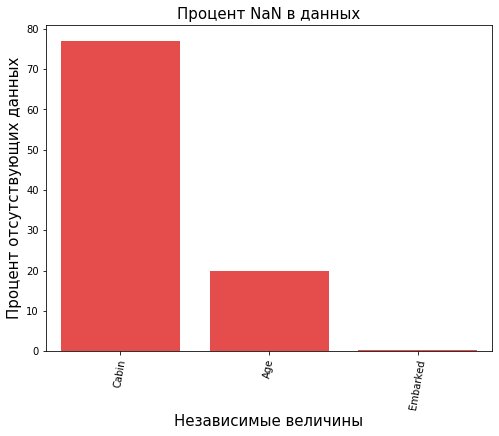

In [54]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='80')
    fig=sns.barplot(ms.index, ms["Percent"],color="red",alpha=0.8)
    plt.xlabel('Независимые величины', fontsize=15)
    plt.ylabel('Процент отсутствующих данных', fontsize=15)
    plt.title('Процент NaN в данных', fontsize=15)
    return ms

missingdata(data)

Посмотрим, отсутствуют ли в тестовых данных те же самые величины.

In [55]:
url=r"C:\Users\af.sabirova\Desktop\pyda\3 модуль ДЗ\3.4\test.csv"
test=pd.read_csv(url)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


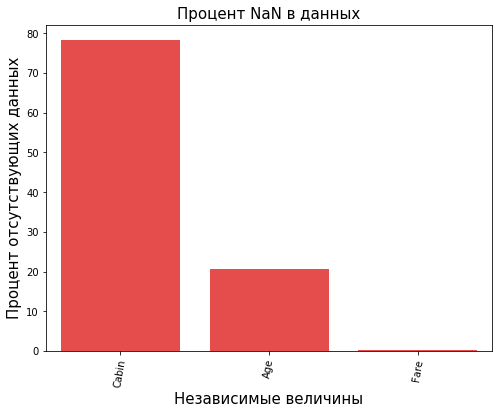

In [56]:
missingdata(test)

Как вариант, можно заполнить неизвестные данные по правилу медианного фильтра: вместо Nan можно использовать среднее значение

In [57]:
test['Age'].fillna(test['Age'].median(), inplace = True)
data['Age'].fillna(data['Age'].median(), inplace = True)

То же самое делаем со значением Fare 

In [58]:
test['Fare'].fillna(test['Fare'].median(), inplace = True)

Нам не нужны значения 'Cabin', так как это просто номер кабины - удаляем колонку

In [59]:
drop_column = ['Cabin']
data.drop(drop_column, axis=1, inplace = True)
test.drop(drop_column,axis=1,inplace=True)

Значение Embarked есть отсутствующие значения в таблице тренировочных данных, но нет в тестовых, поэтому в случае с тестовыми данными мы можем например использовать наиболее встречаемое значение в качестве заполнения неизвестных (так называемую моду - значение признака, имеющее наибольшую частоту в статистическом ряду распределения)

In [60]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)

Проверим, имеются ли отсутствующие значения в данных

In [61]:
print('train data:')
print(data.isnull().sum())
print('test data:')
print(test.isnull().sum())

train data:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
test data:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Можно сказать, успешно избавились от выбросов путем заполнения данных с помощью медианы и моды

Объединим теперь данные в один вектор для дальнейших действий

In [62]:
all_data=[data,test]

Нам не нужны имена, но мы можем использовать такие данные, как Miss, Mister, Mademoiselle (эти данные могут говорить о происхождение человека - англичане), поэтому имеет смысл из имен вычленить только значения Miss

In [63]:
import re
# Библиотека re - для применения регулярных выражений
# Let us then extract second word from every row and assign it to a new column. Not only that let us make it categorical (so that we can one-hot encode it) where we observe the most frequent ones.


def title_parser(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Проверяем если значение есть, то возвращаем его, если нет, то возвращаем ''
    if title_search:
        return title_search.group(1)
    return ""
# Создаем новую колонку 'Title' для титула
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(title_parser)
# Если встречаются непонятные титулы, называем их irrelevant
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'irrelevant')
# Некоторые значения также означают Miss - Mlle, Ms, а вот Mme (Madame) означает Mrs
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Тренировочные данные

In [64]:
all_data[0][:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs


Тестовые данные

In [65]:
all_data[1][:4]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr


In [66]:
data[:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs


In [67]:
test[:4]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr


На основе имеющихся значений мы можем создать новые:

In [68]:
# Создаем новое значение FamilySize как комбинацию SibSp и Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    ## создаем Age_bin для значения age 
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

# Создадим класс для fare 
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

Теперь появились новые колонки, которые также могут нести какой-то смысл

In [69]:
data[:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Age_bin,Fare_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,2,Adult,Low_fare
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,2,Adult,high_fare
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1,Adult,median_fare
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,2,Adult,high_fare


Мы можем удалить такие значения как Name и Ticket, так как из Name мы создали категорированные данные (Miss, Mister, Mrs), а номер билета все равно ни о чем не говорит, поэтому удаляем эти колонки

In [70]:
for dataset in all_data:
    drop_column = ['Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

In [71]:
data[:4]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,Age_bin,Fare_bin
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,2,Adult,Low_fare
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,2,Adult,high_fare
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,1,Adult,median_fare
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,2,Adult,high_fare


Так как у нас получилось много данных категорийных, мы можем заменить эти колонки на вектора (one-hot encoding), таким образом легче для сравнения этих значений

In [72]:
data_new = pd.get_dummies(data, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

test_new = pd.get_dummies(test, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

data_new.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'FamilySize', 'Sex_female', 'Sex_male', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_irrelevant', 'Age_type_Children',
       'Age_type_Teenage', 'Age_type_Adult', 'Age_type_Elder', 'Em_type_C',
       'Em_type_Q', 'Em_type_S', 'Fare_type_Low_fare', 'Fare_type_median_fare',
       'Fare_type_Average_fare', 'Fare_type_high_fare'],
      dtype='object')

Получилось довольно много переменных, но насколько эти переменные имеют значение? Некоторые переменные можно исключить, так как они не несут никакой информации (сильно кореллированы с другими переменными). Нарисуем матрицу теплоты для того, чтобы показать корелляцию между переменными. Значение корелляции Пирсона в ячейках матрицы говорит о величине корелляции

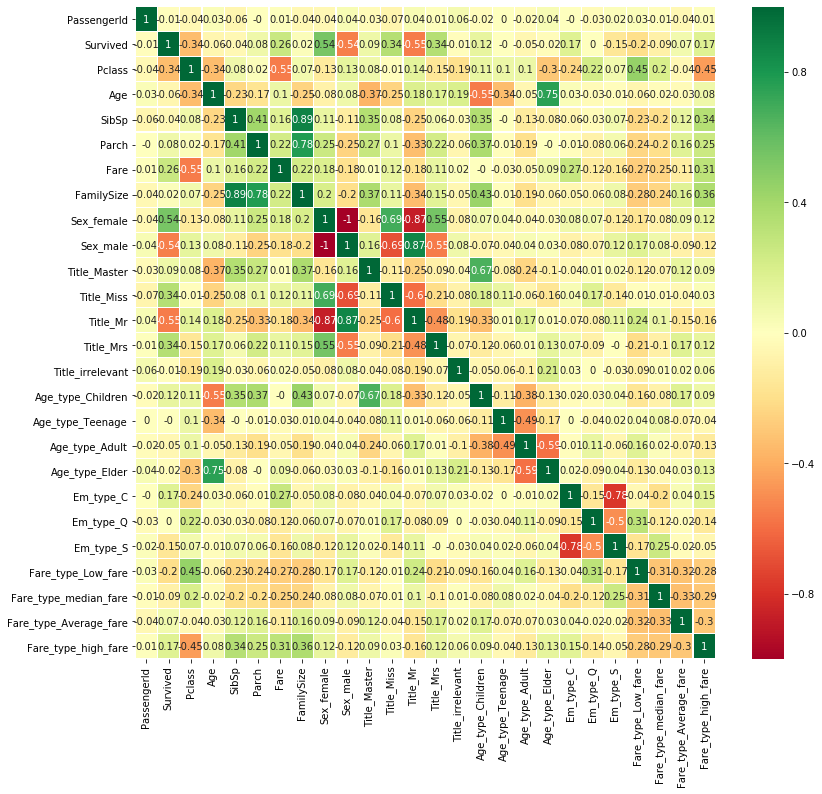

In [73]:
correlation_matrix = data_new.corr(method ='pearson').round(2)
# annot = True чтобы печатать значение внутри ячейки матрицы
sns.heatmap(data=correlation_matrix, yticklabels=True,xticklabels=True, annot=True, cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(13,12)
plt.show()

Можно например объединить такие переменные, которые имеют корелляцию больше чем 70% (красные и зеленые ячейки)

In [74]:
corr_matrix = data_new.corr().abs()

# выбирается верхний треугольник матрицы корелляций (она же симметрична)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# найдем индексы колонок с корелляцией больше чем 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print(to_drop)

['FamilySize', 'Sex_male', 'Title_Mr', 'Age_type_Elder', 'Em_type_S']


In [75]:
data_new = data_new.drop(data_new[to_drop], axis=1)
test_new = test_new.drop(test_new[to_drop], axis=1)

In [76]:
data_new[:2]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Title_Master,Title_Miss,...,Title_irrelevant,Age_type_Children,Age_type_Teenage,Age_type_Adult,Em_type_C,Em_type_Q,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,1,0,3,22.0,1,0,7.2500,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1,1,38.0,1,0,71.2833,1,0,0,...,0,0,0,1,1,0,0,0,0,1


Нормирование числовых данных

In [77]:
from sklearn.preprocessing import MinMaxScaler

# конвертируем данные Series в Numeric
data_new[['Age','Fare']] = data_new[['Age',"Fare"]].apply(pd.to_numeric)
test_new[['Age','Fare']] = test_new[['Age',"Fare"]].apply(pd.to_numeric)

In [78]:
# нормализуем данные от 0 до 1
scaler = MinMaxScaler()
data_new[['Age','Fare']] = scaler.fit_transform(data_new[['Age',"Fare"]])
test_new[['Age','Fare']] = scaler.fit_transform(test_new[['Age',"Fare"]])

Удаляем Id пассажира (так как не несет смысловой нагрузки)

In [79]:
#удаляем id пассажира
drop_column = ['PassengerId']
data_new.drop(drop_column, axis=1, inplace = True)
train_X = data_new.drop("Survived", axis=1)#колонка Survived идет в новую переменную - Y output
train_Y=data_new["Survived"]
test_X  = test_new.drop("PassengerId", axis=1).copy() 

In [80]:
train_X.shape, train_Y.shape, test_X.shape

((891, 19), (891,), (418, 19))

Применим алгоритм логистической регрессии для тренировочных данных:

In [81]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X,
                                                 train_Y,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
model = LogisticRegression()
model.fit(X_train, y_train)
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test,predicted_classes)
print('Точность предсказания модели: ', accuracy)
parameters = model.coef_

Точность предсказания модели:  0.7947761194029851


C:\Users\af.sabirova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [89]:
y = train_Y

X = train_X
X
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [91]:
from sklearn import tree
my_d_tree = tree.DecisionTreeClassifier(max_depth = 10, min_samples_split = 5, random_state = 1)
my_d_tree = my_d_tree.fit(X_train, y_train)

In [92]:
print(my_d_tree.feature_importances_) 
print(my_d_tree.score(X, y))

[0.14007075 0.16117853 0.05492528 0.01551617 0.16469462 0.40098541
 0.         0.         0.00145059 0.         0.00317004 0.00661928
 0.01661322 0.01696072 0.00145059 0.         0.00908326 0.00728155
 0.        ]
0.877665544332211


Попробуем метод Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(max_depth = 10, min_samples_split=2, n_estimators = 100, random_state = 1)
my_forest = forest.fit(X_train, y_train)


print(my_forest.score(X, y))
print(my_d_tree.feature_importances_)

0.9034792368125701
[0.14007075 0.16117853 0.05492528 0.01551617 0.16469462 0.40098541
 0.         0.         0.00145059 0.         0.00317004 0.00661928
 0.01661322 0.01696072 0.00145059 0.         0.00908326 0.00728155
 0.        ]


Данная модель дала точность предсказания 90.3%

Справочно посмотрим профайлинг (как вариант исследования переменных)

In [86]:
pip install pandas_profiling

  Stored in directory: C:\Users\af.sabirova\AppData\Local\pip\Cache\wheels\ce\c7\f1\dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Stored in directory: C:\Users\af.sabirova\AppData\Local\pip\Cache\wheels\43\07\ac\7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Stored in directory: C:\Users\af.sabirova\AppData\Local\pip\Cache\wheels\b0\b2\96\2074eee7dbf7b7df69d004c9b6ac4e32dad04fb7666cf943bd
Successfully built pandas-profiling htmlmin confuse
Note: you may need to restart the kernel to use updated packages.


In [87]:
import pandas_profiling
data.profile_report()